## I. Data Handling

In [4]:
from pandas_datareader import DataReader
import pandas_datareader.data as web
from datetime import date
import pandas as pd
from pandas import (to_datetime, DatetimeIndex, Period)
import yfinance as yf
import numpy as np
import math
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
series_code = ['DTB4WK', 'DGS10', 'DGS5', 'TB3MS']
data_source = 'fred'
start = date(2001, 7, 31)
data = DataReader(series_code, data_source, start)
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5765 entries, 2001-07-31 to 2023-05-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTB4WK  5455 non-null   float64
 1   DGS10   5455 non-null   float64
 2   DGS5    5455 non-null   float64
 3   TB3MS   261 non-null    float64
dtypes: float64(4)
memory usage: 225.2 KB
None


,DTB4WK,DGS10,DGS5,TB3MS
DATE,,,,
2001-07-31,3.61,5.07,4.57,NaN
2001-08-01,3.60,5.11,4.62,3.36
2001-08-02,3.60,5.17,4.69,NaN
2001-08-03,3.58,5.20,4.72,NaN
2001-08-06,3.58,5.19,4.71,NaN


In [11]:
# Index date to separate column
data.index.name = 'DATE'
data.reset_index(inplace=True)
data.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS
0,2001-07-31,3.61,5.07,4.57,NaN
1,2001-08-01,3.60,5.11,4.62,3.36
2,2001-08-02,3.60,5.17,4.69,NaN
3,2001-08-03,3.58,5.20,4.72,NaN
4,2001-08-06,3.58,5.19,4.71,NaN


In [12]:
# Monthly averages
avg_list = ['DTB4WK', 'DGS10', 'DGS5', 'TB3MS']
data = data.groupby([pd.PeriodIndex(data['DATE'], freq="M")])[avg_list].mean()

### Term Spread

In [6]:
data['excess'] = data['DGS10'] - data['DTB4WK']
data['term_spread'] = data['DGS5'] - data['TB3MS']

In [7]:
data.index.name = 'DATE'
data.reset_index(inplace=True)
data.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread
0,2001-07,3.610000,5.070000,4.570000,NaN,1.460000,NaN
1,2001-08,3.483478,4.971304,4.573913,3.36,1.487826,1.213913
2,2001-09,2.631176,4.731765,4.115294,2.64,2.100588,1.475294
3,2001-10,2.237727,4.566818,3.910000,2.16,2.329091,1.750000
4,2001-11,1.964500,4.651500,3.972500,1.87,2.687000,2.102500


In [8]:
# Convert the PeriodIndex column in df1 to a regular datetime column
data['DATE'] = data['DATE'].dt.to_timestamp()

In [9]:
inflation_df = pd.read_csv('CPIAUCSL.csv')
inflation_df.head()

,DATE,CPIAUCSL_PC1
0,2001-07,2.7215
1,2001-08,2.7215
2,2001-09,2.5922
3,2001-10,2.1277
4,2001-11,1.8944


In [12]:
# Convert the PeriodIndex column in df1 to a regular datetime column
inflation_df['DATE'].info()
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])

<class 'pandas.core.series.Series'>
RangeIndex: 260 entries, 0 to 259
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
260 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.2 KB


In [13]:
# Join inflation_df into data
data = pd.merge(data, inflation_df, on = 'DATE')
data.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread,CPIAUCSL_PC1
0,2001-07-01,3.610000,5.070000,4.570000,NaN,1.460000,NaN,2.7215
1,2001-08-01,3.483478,4.971304,4.573913,3.36,1.487826,1.213913,2.7215
2,2001-09-01,2.631176,4.731765,4.115294,2.64,2.100588,1.475294,2.5922
3,2001-10-01,2.237727,4.566818,3.910000,2.16,2.329091,1.750000,2.1277
4,2001-11-01,1.964500,4.651500,3.972500,1.87,2.687000,2.102500,1.8944


### Real Yield

In [14]:
data['real_yield'] = data['DGS5'] - data['CPIAUCSL_PC1']

In [15]:
data.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread,CPIAUCSL_PC1,real_yield
0,2001-07-01,3.610000,5.070000,4.570000,NaN,1.460000,NaN,2.7215,1.848500
1,2001-08-01,3.483478,4.971304,4.573913,3.36,1.487826,1.213913,2.7215,1.852413
2,2001-09-01,2.631176,4.731765,4.115294,2.64,2.100588,1.475294,2.5922,1.523094
3,2001-10-01,2.237727,4.566818,3.910000,2.16,2.329091,1.750000,2.1277,1.782300
4,2001-11-01,1.964500,4.651500,3.972500,1.87,2.687000,2.102500,1.8944,2.078100


### Inverse Wealth

In [16]:
# Load historical monthly data for S&P 500 returns
# Set the ticker symbol for the S&P 500 index
ticker = "^GSPC"

# Define the start and end dates for the data
start_date = "2000-01-01"
end_date = "2023-03-01"

# Use the yfinance library to get the monthly SP500 data
sp500_data = yf.download(ticker, start=start_date, end=end_date, interval="1mo")

# Print the first 5 rows of the data
sp500_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-01,1469.250000,1478.000000,1350.140015,1394.459961,1394.459961,21494400000
2000-02-01,1394.459961,1444.550049,1325.069946,1366.420044,1366.420044,20912000000
2000-03-01,1366.420044,1552.869995,1346.619995,1498.579956,1498.579956,26156200000
2000-04-01,1498.579956,1527.189941,1339.400024,1452.430054,1452.430054,20106460000
2000-05-01,1452.430054,1481.510010,1361.089966,1420.599976,1420.599976,19898300000


In [17]:
# Make index a column
sp500_data.index.name = 'DATE'
sp500_data.reset_index(inplace=True)

In [18]:
# Change date format to yyyy-mm
sp500_data['DATE'] = pd.to_datetime(sp500_data['DATE']).dt.strftime("%Y-%m")
sp500_data.head()

,DATE,Open,High,Low,Close,Adj Close,Volume
0,2000-01,1469.250000,1478.000000,1350.140015,1394.459961,1394.459961,21494400000
1,2000-02,1394.459961,1444.550049,1325.069946,1366.420044,1366.420044,20912000000
2,2000-03,1366.420044,1552.869995,1346.619995,1498.579956,1498.579956,26156200000
3,2000-04,1498.579956,1527.189941,1339.400024,1452.430054,1452.430054,20106460000
4,2000-05,1452.430054,1481.510010,1361.089966,1420.599976,1420.599976,19898300000


In [19]:
# Set the decay factor
decay_factor = 0.9

# Calculate the exponentially weighted moving average of past SP500 level
sp500_data['EWMA'] = sp500_data['Adj Close'].ewm(alpha=1-decay_factor, adjust=False).mean()

# Calculate ratio of the exponentially weighted past SP500 level to the current stock market level
sp500_data['inv_wealth'] = sp500_data['EWMA'].iloc[1:] * 0.1 / sp500_data['Adj Close']

sp500_data.head()

,DATE,Open,High,Low,Close,Adj Close,Volume,EWMA,inv_wealth
0,2000-01,1469.250000,1478.000000,1350.140015,1394.459961,1394.459961,21494400000,1394.459961,NaN
1,2000-02,1394.459961,1444.550049,1325.069946,1366.420044,1366.420044,20912000000,1391.655969,0.101847
2,2000-03,1366.420044,1552.869995,1346.619995,1498.579956,1498.579956,26156200000,1402.348368,0.093578
3,2000-04,1498.579956,1527.189941,1339.400024,1452.430054,1452.430054,20106460000,1407.356536,0.096897
4,2000-05,1452.430054,1481.510010,1361.089966,1420.599976,1420.599976,19898300000,1408.680880,0.099161


In [20]:
sp500_data['DATE'] = pd.to_datetime(sp500_data['DATE'])
sp500_data['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 278 entries, 0 to 277
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
278 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.3 KB


In [21]:
# Join SP500 with data
data_full = pd.merge(data, sp500_data, on = 'DATE')
data_full.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread,CPIAUCSL_PC1,real_yield,Open,High,Low,Close,Adj Close,Volume,EWMA,inv_wealth
0,2001-07-01,3.610000,5.070000,4.570000,NaN,1.460000,NaN,2.7215,1.848500,1224.420044,1239.780029,1165.540039,1211.229980,1211.229980,23793710000,1318.557094,0.108861
1,2001-08-01,3.483478,4.971304,4.573913,3.36,1.487826,1.213913,2.7215,1.852413,1211.229980,1226.270020,1124.869995,1133.579956,1133.579956,23359200000,1300.059380,0.114686
2,2001-09-01,2.631176,4.731765,4.115294,2.64,2.100588,1.475294,2.5922,1.523094,1133.579956,1155.400024,944.750000,1040.939941,1040.939941,25025290000,1274.147436,0.122404
3,2001-10-01,2.237727,4.566818,3.910000,2.16,2.329091,1.750000,2.1277,1.782300,1040.939941,1110.609985,1026.760010,1059.780029,1059.780029,29951280000,1252.710696,0.118205
4,2001-11-01,1.964500,4.651500,3.972500,1.87,2.687000,2.102500,1.8944,2.078100,1059.780029,1163.380005,1054.310059,1139.449951,1139.449951,26330000000,1241.384621,0.108946


### Momentum

In [22]:
# Calculate the 6-month rolling average intervals of Real Bond Yield
data_full['rolling_6m'] = data_full['real_yield'].rolling(window=6).mean()

In [23]:
data_full['rolling_6m'] = data_full['rolling_6m'].shift(periods=1)
data_full.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread,CPIAUCSL_PC1,real_yield,Open,High,Low,Close,Adj Close,Volume,EWMA,inv_wealth,rolling_6m
0,2001-07-01,3.610000,5.070000,4.570000,NaN,1.460000,NaN,2.7215,1.848500,1224.420044,1239.780029,1165.540039,1211.229980,1211.229980,23793710000,1318.557094,0.108861,NaN
1,2001-08-01,3.483478,4.971304,4.573913,3.36,1.487826,1.213913,2.7215,1.852413,1211.229980,1226.270020,1124.869995,1133.579956,1133.579956,23359200000,1300.059380,0.114686,NaN
2,2001-09-01,2.631176,4.731765,4.115294,2.64,2.100588,1.475294,2.5922,1.523094,1133.579956,1155.400024,944.750000,1040.939941,1040.939941,25025290000,1274.147436,0.122404,NaN
3,2001-10-01,2.237727,4.566818,3.910000,2.16,2.329091,1.750000,2.1277,1.782300,1040.939941,1110.609985,1026.760010,1059.780029,1059.780029,29951280000,1252.710696,0.118205,NaN
4,2001-11-01,1.964500,4.651500,3.972500,1.87,2.687000,2.102500,1.8944,2.078100,1059.780029,1163.380005,1054.310059,1139.449951,1139.449951,26330000000,1241.384621,0.108946,NaN


In [24]:
# Momentum (Dummy): 1 if < 6m_avg, -1 if > 6m_avg, 0 if otherwise
data_full['momentum'] = np.where(data_full['real_yield'] < (data_full['rolling_6m'] + 0.0005), 1, 
                        np.where(data_full['real_yield'] > (data_full['rolling_6m'] + 0.0005), -1, 
                                                                                               0))

In [25]:
data_full.head()

,DATE,DTB4WK,DGS10,DGS5,TB3MS,excess,term_spread,CPIAUCSL_PC1,real_yield,Open,High,Low,Close,Adj Close,Volume,EWMA,inv_wealth,rolling_6m,momentum
0,2001-07-01,3.610000,5.070000,4.570000,NaN,1.460000,NaN,2.7215,1.848500,1224.420044,1239.780029,1165.540039,1211.229980,1211.229980,23793710000,1318.557094,0.108861,NaN,0
1,2001-08-01,3.483478,4.971304,4.573913,3.36,1.487826,1.213913,2.7215,1.852413,1211.229980,1226.270020,1124.869995,1133.579956,1133.579956,23359200000,1300.059380,0.114686,NaN,0
2,2001-09-01,2.631176,4.731765,4.115294,2.64,2.100588,1.475294,2.5922,1.523094,1133.579956,1155.400024,944.750000,1040.939941,1040.939941,25025290000,1274.147436,0.122404,NaN,0
3,2001-10-01,2.237727,4.566818,3.910000,2.16,2.329091,1.750000,2.1277,1.782300,1040.939941,1110.609985,1026.760010,1059.780029,1059.780029,29951280000,1252.710696,0.118205,NaN,0
4,2001-11-01,1.964500,4.651500,3.972500,1.87,2.687000,2.102500,1.8944,2.078100,1059.780029,1163.380005,1054.310059,1139.449951,1139.449951,26330000000,1241.384621,0.108946,NaN,0


In [28]:
data_sub = data_full[['DATE', 'excess', 'term_spread', 'real_yield', 'inv_wealth', 'rolling_6m', 'momentum', 'DTB4WK', 'DGS10', 'DGS5', 'TB3MS']]
data_sub.to_csv('exc_ret_btest.csv', index=False)

In [26]:
data_mdl = data_full[['DATE', 'excess', 'term_spread', 'real_yield', 'inv_wealth', 'rolling_6m', 'momentum']]
data_mdl.head()

,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum
0,2001-07-01,1.460000,NaN,1.848500,0.108861,NaN,0
1,2001-08-01,1.487826,1.213913,1.852413,0.114686,NaN,0
2,2001-09-01,2.100588,1.475294,1.523094,0.122404,NaN,0
3,2001-10-01,2.329091,1.750000,1.782300,0.118205,NaN,0
4,2001-11-01,2.687000,2.102500,2.078100,0.108946,NaN,0


In [27]:
# Save data for modeling
data_mdl.to_csv('exc_ret_modeling.csv', index=False)

## II. Modeling

In [31]:
exc_ret_mdl = pd.read_csv('exc_ret_modeling.csv')
exc_ret_mdl = exc_ret_mdl.dropna()
exc_ret_mdl.head()
exc_ret_mdl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 6 to 259
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         254 non-null    object 
 1   excess       254 non-null    float64
 2   term_spread  254 non-null    float64
 3   real_yield   254 non-null    float64
 4   inv_wealth   254 non-null    float64
 5   rolling_6m   254 non-null    float64
 6   momentum     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


In [32]:
# Convert momentum into categorical variable
exc_ret_mdl['momentum'] = exc_ret_mdl.momentum.astype('category')
exc_ret_mdl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 6 to 259
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   DATE         254 non-null    object  
 1   excess       254 non-null    float64 
 2   term_spread  254 non-null    float64 
 3   real_yield   254 non-null    float64 
 4   inv_wealth   254 non-null    float64 
 5   rolling_6m   254 non-null    float64 
 6   momentum     254 non-null    category
dtypes: category(1), float64(5), object(1)
memory usage: 14.3+ KB


In [33]:
# Save data for modeling
exc_ret_mdl.to_csv('exc_ret_modeling.csv', index=False)

In [78]:
# Correlation Matrix
corr_matrix = exc_ret_mdl.drop('rolling_6m', axis=1).corr(numeric_only = True)
corr_matrix

,excess,term_spread,real_yield,inv_wealth
excess,1.00000,0.964200,0.150080,0.265190
term_spread,0.96420,1.000000,0.189659,0.273235
real_yield,0.15008,0.189659,1.000000,0.221932
inv_wealth,0.26519,0.273235,0.221932,1.000000


<AxesSubplot:>

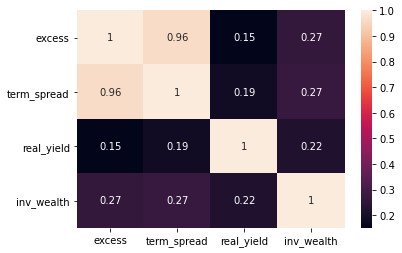

In [79]:
# Correlation heatmap
# Increase the size of the heatmap.
#plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(exc_ret_mdl.drop('rolling_6m', axis=1).corr(numeric_only = True), annot=True)
heatmap

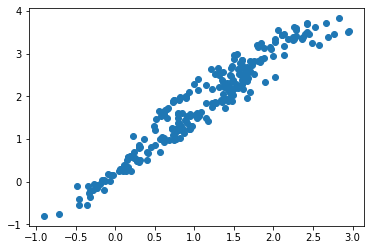

In [80]:
# Excess and term spread are highly correlated
# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(exc_ret_mdl['term_spread'], exc_ret_mdl['excess'])
plt.show()

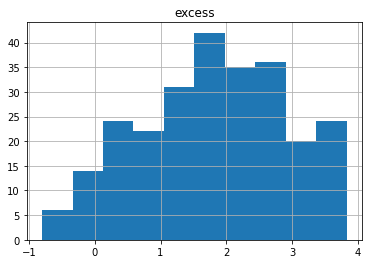

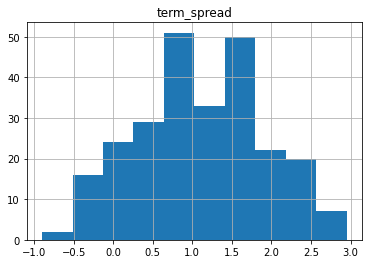

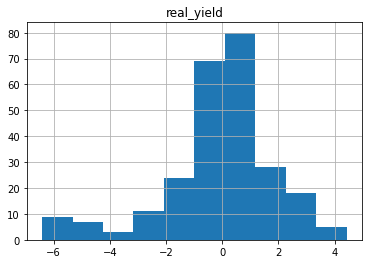

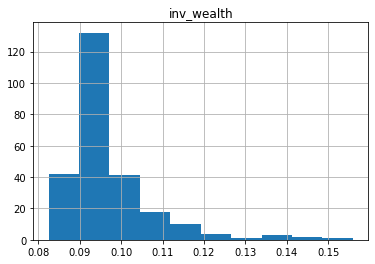

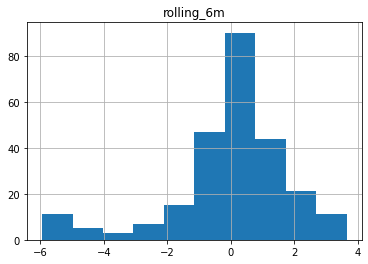

In [81]:
# Variable distribution
for col_name, col_data in exc_ret_mdl.drop(['DATE', 'momentum'], axis = 1).items():
    col_data.hist()
    plt.title(col_name)
    plt.show()

In [10]:
# Define dependent variable and independent variables
targets = exc_ret_mdl['excess']
features = exc_ret_mdl[['term_spread', 'real_yield', 'inv_wealth', 'momentum']]

#### Train & Test

In [11]:
# Add a constant to the feature before we fit our linear model
# so we have an intercept for our linear model.
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85* features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(254, 5) (215, 5) (39, 5)


/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Multiple LR

In [12]:
# fit the multiple linear regression model
mlr = sm.OLS(targets, linear_features).fit()

# get the full model report
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     838.4
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          3.95e-143
Time:                        16:29:27   Log-Likelihood:                -45.203
No. Observations:                 254   AIC:                             100.4
Df Residuals:                     249   BIC:                             118.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2347      0.172      1.363      

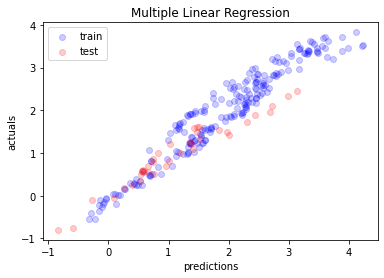

In [13]:
# Make predictions from our model for train and test sets
mlr_train_predictions = mlr.predict(train_features)
mlr_test_predictions = mlr.predict(test_features)

# Plot mlr predictions
plt.scatter(mlr_train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(mlr_test_predictions, test_targets, alpha = 0.2, color='r', label='test')
plt.title('Multiple Linear Regression')
plt.xlabel('predictions')
plt.ylabel('actuals')
plt.legend()
plt.show()

In [54]:
from sklearn.preprocessing import scale
# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Create rf model, fit to train set
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(train_features, train_targets)

# R-squared scores on train & tests
print(rf.score(train_features, train_targets))
print(rf.score(test_features, test_targets))

0.9952643149108342
0.5839471625473185


#### Tune RF parameters

In [28]:
from sklearn.model_selection import ParameterGrid

# Dictionary of hyperparameters
grid = {'n_estimators': [500], 'max_depth': [3], 'max_features': [2, 4], 'random_state': [269]}
test_scores = []

# Loop through grid, set hyperparameter, save scores into list
for g in ParameterGrid(grid):
    rf.set_params(**g) #unpacking the dictionary
    rf.fit(train_features, train_targets)
    test_scores.append(rf.score(test_features, test_targets))
    
# Return best hyperparameters from test score
best_param_idx = np.argmax(test_scores)
print(test_scores[best_param_idx], ParameterGrid(grid)[best_param_idx])

0.553754843005419 {'random_state': 269, 'n_estimators': 500, 'max_features': 4, 'max_depth': 3}


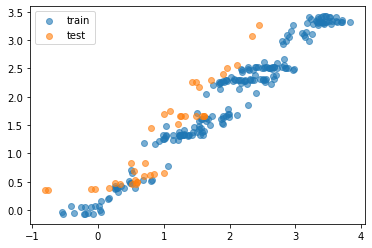

In [29]:
# Refit RF model using best parameters
rf = RandomForestRegressor(n_estimators = 500, max_depth = 3, max_features = 4)
rf.fit(train_features, train_targets)

# Make predictions
rf_train_predictions = rf.predict(train_features)
rf_test_predictions = rf.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, rf_train_predictions, alpha = 0.6, label='train')
plt.scatter(test_targets, rf_test_predictions, alpha = 0.6, label='test')
plt.legend()
plt.show()

#### Feature Importance

['term_spread' 'inv_wealth' 'real_yield' 'momentum']


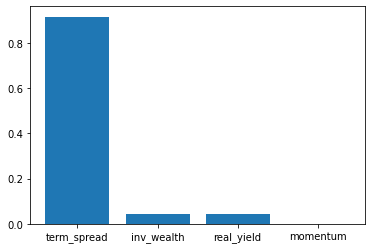

In [30]:
feature_names = ['term_spread', 'real_yield', 'inv_wealth', 'momentum']

# get feature importances from RF model
importance = rf.feature_importances_
importance = importance[1:]

# Index importances from greatest to lowest
sorted_imp = np.argsort(importance)[::-1]
mask = sorted_imp < len(feature_names)

# Create a range of values for the x-axis
x = range(len(importance))

# Create tick labels for each feature in the same order as importance
labels = np.array(feature_names)[sorted_imp[mask]]
print(labels)

# Create a bar chart
plt.bar(x, importance[sorted_imp], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks()
plt.show()

### Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=500,
                                subsample=0.6,
                                random_state=269)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.9857245665889747
0.37594157214140567


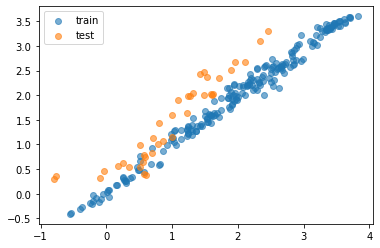

In [32]:
# Make predictions
gb_train_predictions = gbr.predict(train_features)
gb_test_predictions = gbr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, gb_train_predictions, alpha = 0.6, label='train')
plt.scatter(test_targets, gb_test_predictions, alpha = 0.6, label='test')
plt.legend()
plt.show()

['term_spread' 'real_yield' 'inv_wealth' 'momentum']


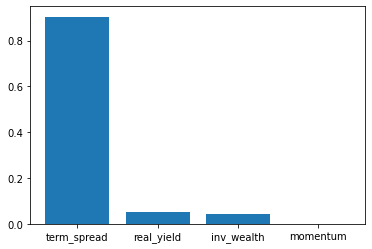

In [33]:
# get feature importances from GB model
importance = gbr.feature_importances_
importance = importance[1:]

# Index importances from greatest to lowest
sorted_imp = np.argsort(importance)[::-1]
mask = sorted_imp < len(feature_names)

# Create a range of values for the x-axis
x = range(len(importance))

# Create tick labels for each feature in the same order as importance
labels = np.array(feature_names)[sorted_imp[mask]]
print(labels)

# Create a bar chart
plt.bar(x, importance[sorted_imp], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks()
plt.show()

### K-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 21): #range from 2 to 12
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(train_features, train_targets))
    print(knn.score(test_features, test_targets))
    print()  # prints a blank line
    
# n = 17 is the best number of neighbors based on the TEST scores

n_neighbors = 2
train, test scores
0.9794644571921072
-0.6093487285555412

n_neighbors = 3
train, test scores
0.9736566541157134
-0.6136745642365473

n_neighbors = 4
train, test scores
0.9661114034019547
-0.6353291399035503

n_neighbors = 5
train, test scores
0.9604784438210099
-0.7084849414226837

n_neighbors = 6
train, test scores
0.957440646606054
-0.7070877899484962

n_neighbors = 7
train, test scores
0.9522594068429091
-0.816669492549768

n_neighbors = 8
train, test scores
0.9467627546253913
-0.8505074476648162

n_neighbors = 9
train, test scores
0.9411154504127934
-0.926548661508307

n_neighbors = 10
train, test scores
0.9394671511157119
-0.8452105164445778

n_neighbors = 11
train, test scores
0.9368132659307477
-0.8217723485473782

n_neighbors = 12
train, test scores
0.9317574972701842
-0.8708871646989818

n_neighbors = 13
train, test scores
0.9252755785908028
-0.8479223377267682

n_neighbors = 14
train, test scores
0.9234209396523618
-0.8543225536364987

n_neighbors = 15
train,

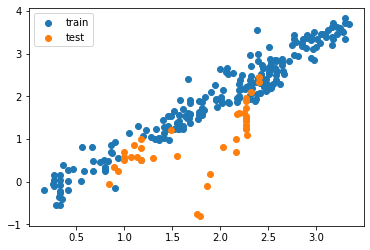

In [36]:
# Create the model with the best-performing n_neighbors of 17
knn = KNeighborsRegressor(n_neighbors = 17)

# Fit the model
knn.fit(train_features, train_targets)

# Get predictions for train and test sets
knn_train_predictions = knn.predict(train_features)
knn_test_predictions = knn.predict(test_features)

# Plot the actual vs predicted values
plt.scatter(knn_train_predictions, train_targets, label='train')
plt.scatter(knn_test_predictions, test_targets, label='test')
plt.legend()
plt.show()

In [58]:
# Concat Algo Preds + Train/Test Targets

train_actual_pred = pd.DataFrame({'date': exc_ret_mdl[:train_size]['DATE'], 'momentum': exc_ret_mdl[:train_size]['momentum'], 'train_actuals': train_targets, 'Multiple Linear Regression': mlr_train_predictions, 'Random Forest': rf_train_predictions, 'Gradient Boosting': gb_train_predictions, 'K-Nearest Neighbor': knn_train_predictions})
test_actual_pred = pd.DataFrame({'date': exc_ret_mdl[train_size:]['DATE'], 'momentum': exc_ret_mdl[train_size:]['momentum'], 'test_actuals': test_targets, 'Multiple Linear Regression': mlr_test_predictions, 'Random Forest': rf_test_predictions, 'Gradient Boosting': gb_test_predictions, 'K-Nearest Neighbor': knn_test_predictions})

print(train_actual_pred.head())
print(test_actual_pred.head())

# Save algo predictions into csvs

train_actual_pred.to_csv('train_preds.csv', index = False)
test_actual_pred.to_csv('test_preds.csv', index = False)

         date  momentum  train_actuals  Multiple Linear Regression  \
0  2002-01-01        -1       3.389524                    3.889495   
1  2002-02-01        -1       3.207895                    3.739925   
2  2002-03-01        -1       3.534000                    4.229774   
3  2002-04-01        -1       3.518636                    4.227071   
4  2002-05-01        -1       3.456364                    3.989917   

   Random Forest  Gradient Boosting  K-Nearest Neighbor  
0       3.409467           3.421144            3.159578  
1       3.406305           3.395734            3.159578  
2       3.412953           3.511214            3.266043  
3       3.411603           3.486045            3.282168  
4       3.417713           3.464754            3.211575  
           date  momentum  test_actuals  Multiple Linear Regression  \
215  2019-12-01         1      0.339524                    0.524260   
216  2020-01-01         1      0.254286                    0.396569   
217  2020-02-01   

### Monthly Rolling Regression

In [34]:
# Reload dataset
import pandas as pd
import statsmodels.api as sm
exc_ret_mdl = pd.read_csv('exc_ret_modeling.csv', index_col='DATE', parse_dates=True)

In [35]:
# initializes the window size to 12 
init_window_size = 12 

# loops over each row of the exc_ret_mdl DataFrame and incrementally expands historical sample
results = pd.DataFrame(columns=['intercept', 'term_spread_b1', 'real_yield_b2', 'inv_wealth_b3', 'momentum_b4', 'r_squared'])

for i in range(init_window_size, len(exc_ret_mdl)):
    # Get expanding window of data
    window = exc_ret_mdl.iloc[:i]
    
    # Define dependent and independent variables
    x = window[['term_spread', 'real_yield', 'inv_wealth', 'momentum']]
    y = window['excess']
    
    # Fit OLS model
    x = sm.add_constant(x)
    rolling_mlr = sm.OLS(y, x).fit()
    
    # Save results
    results.loc[exc_ret_mdl.index[i]] = [rolling_mlr.params[0], rolling_mlr.params[1], rolling_mlr.params[2], rolling_mlr.params[3], rolling_mlr.params[4], rolling_mlr.rsquared]

# Print results
results

/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phaml

/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phaml

/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phaml

/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phamlinhchi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/phaml

,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared
2003-01-01,1.448106,0.920469,-0.067947,-2.867111,0.060752,0.994637
2003-02-01,1.392026,0.932458,-0.074075,-2.487139,0.059815,0.994604
2003-03-01,1.502757,0.909035,-0.059093,-3.299866,0.064760,0.993921
2003-04-01,1.454100,0.907301,-0.052955,-2.976099,0.066036,0.993376
2003-05-01,1.873867,0.835624,-0.052928,-5.154922,0.035816,0.989065
...,...,...,...,...,...,...
2022-10-01,0.228571,1.345997,-0.020578,0.986665,0.003674,0.926154
2022-11-01,0.236679,1.347162,-0.019514,0.880249,0.005092,0.926282
2022-12-01,0.238223,1.347846,-0.019206,0.853022,0.005594,0.926970
2023-01-01,0.231160,1.345675,-0.019821,0.958516,0.004532,0.927796


In [39]:
# Load full dataset including 10y-5y-1m Bonds
exc_ret_btest = pd.read_csv('exc_ret_btest.csv')

In [40]:
# Join results into exc_ret_mdl
exc_ret_btest_idx = exc_ret_btest.reset_index(drop=False)
exc_ret_btest_idx['DATE'] = pd.to_datetime(exc_ret_btest_idx['DATE'])
exc_ret_btest_idx = exc_ret_btest_idx.drop('index', axis = 1)
results_idx = results.reset_index(drop=False)
expanding_reg = pd.merge(exc_ret_btest_idx, results_idx, how='left', left_on='DATE', right_on = 'index')
expanding_reg

,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum,DTB4WK,DGS10,DGS5,TB3MS,index,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared
0,2001-07-01,1.460000,NaN,1.848500,0.108861,NaN,0,3.610000,5.070000,4.570000,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-08-01,1.487826,1.213913,1.852413,0.114686,NaN,0,3.483478,4.971304,4.573913,3.36,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-09-01,2.100588,1.475294,1.523094,0.122404,NaN,0,2.631176,4.731765,4.115294,2.64,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-10-01,2.329091,1.750000,1.782300,0.118205,NaN,0,2.237727,4.566818,3.910000,2.16,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-11-01,2.687000,2.102500,2.078100,0.108946,NaN,0,1.964500,4.651500,3.972500,1.87,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-10-01,0.806000,0.458000,-3.584500,0.104173,-5.331543,-1,3.177500,3.983500,4.178000,3.72,2022-10-01,0.228571,1.345997,-0.020578,0.986665,0.003674,0.926154
256,2022-11-01,0.173000,-0.094500,-3.079900,0.098973,-5.020576,-1,3.718000,3.891000,4.055500,4.15,2022-11-01,0.236679,1.347162,-0.019514,0.880249,0.005092,0.926282
257,2022-12-01,-0.100476,-0.485714,-2.680614,0.104658,-4.595890,-1,3.716667,3.616190,3.764286,4.25,2022-12-01,0.238223,1.347846,-0.019206,0.853022,0.005594,0.926970
258,2023-01-01,-0.800500,-0.897000,-2.704200,0.098714,-4.085493,-1,4.332000,3.531500,3.643000,4.54,2023-01-01,0.231160,1.345675,-0.019821,0.958516,0.004532,0.927796


In [41]:
# Clean & save
expanding_reg_clean = expanding_reg.dropna()
expanding_reg_clean

,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum,DTB4WK,DGS10,DGS5,TB3MS,index,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared
18,2003-01-01,2.898095,1.882381,0.294881,0.118737,1.263831,1,1.150476,4.048571,3.052381,1.17,2003-01-01,1.448106,0.920469,-0.067947,-2.867111,0.060752,0.994637
19,2003-02-01,2.727368,1.727895,-0.248205,0.118711,0.922699,1,1.175263,3.902632,2.897895,1.17,2003-02-01,1.392026,0.932458,-0.074075,-2.487139,0.059815,0.994604
20,2003-03-01,2.650476,1.653810,-0.241390,0.115955,0.623491,1,1.156667,3.807143,2.783810,1.13,2003-03-01,1.502757,0.909035,-0.059093,-3.299866,0.064760,0.993921
21,2003-04-01,2.820476,1.798571,0.753471,0.106536,0.346259,-1,1.138095,3.958571,2.928571,1.13,2003-04-01,1.454100,0.907301,-0.052955,-2.976099,0.066036,0.993376
22,2003-05-01,2.506667,1.445714,0.621514,0.101238,0.318838,-1,1.062381,3.569048,2.515714,1.07,2003-05-01,1.873867,0.835624,-0.052928,-5.154922,0.035816,0.989065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-10-01,0.806000,0.458000,-3.584500,0.104173,-5.331543,-1,3.177500,3.983500,4.178000,3.72,2022-10-01,0.228571,1.345997,-0.020578,0.986665,0.003674,0.926154
256,2022-11-01,0.173000,-0.094500,-3.079900,0.098973,-5.020576,-1,3.718000,3.891000,4.055500,4.15,2022-11-01,0.236679,1.347162,-0.019514,0.880249,0.005092,0.926282
257,2022-12-01,-0.100476,-0.485714,-2.680614,0.104658,-4.595890,-1,3.716667,3.616190,3.764286,4.25,2022-12-01,0.238223,1.347846,-0.019206,0.853022,0.005594,0.926970
258,2023-01-01,-0.800500,-0.897000,-2.704200,0.098714,-4.085493,-1,4.332000,3.531500,3.643000,4.54,2023-01-01,0.231160,1.345675,-0.019821,0.958516,0.004532,0.927796


In [42]:
# Calculate expected excess returns (based on reg parameters)
expanding_reg_clean['expected_excess'] = expanding_reg_clean['intercept'] + \
                                         expanding_reg_clean['term_spread_b1']*expanding_reg_clean['term_spread'] + \
                                         expanding_reg_clean['real_yield_b2']*expanding_reg_clean['real_yield'] + \
                                         expanding_reg_clean['inv_wealth_b3']*expanding_reg_clean['inv_wealth'] + \
                                         expanding_reg_clean['momentum_b4']*expanding_reg_clean['momentum']
expanding_reg_clean

<ipython-input-42-6ef80a06711a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expanding_reg_clean['expected_excess'] = expanding_reg_clean['intercept'] + \


,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum,DTB4WK,DGS10,DGS5,TB3MS,index,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared,expected_excess
18,2003-01-01,2.898095,1.882381,0.294881,0.118737,1.263831,1,1.150476,4.048571,3.052381,1.17,2003-01-01,1.448106,0.920469,-0.067947,-2.867111,0.060752,0.994637,2.881064
19,2003-02-01,2.727368,1.727895,-0.248205,0.118711,0.922699,1,1.175263,3.902632,2.897895,1.17,2003-02-01,1.392026,0.932458,-0.074075,-2.487139,0.059815,0.994604,2.786165
20,2003-03-01,2.650476,1.653810,-0.241390,0.115955,0.623491,1,1.156667,3.807143,2.783810,1.13,2003-03-01,1.502757,0.909035,-0.059093,-3.299866,0.064760,0.993921,2.702518
21,2003-04-01,2.820476,1.798571,0.753471,0.106536,0.346259,-1,1.138095,3.958571,2.928571,1.13,2003-04-01,1.454100,0.907301,-0.052955,-2.976099,0.066036,0.993376,2.662950
22,2003-05-01,2.506667,1.445714,0.621514,0.101238,0.318838,-1,1.062381,3.569048,2.515714,1.07,2003-05-01,1.873867,0.835624,-0.052928,-5.154922,0.035816,0.989065,2.491355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-10-01,0.806000,0.458000,-3.584500,0.104173,-5.331543,-1,3.177500,3.983500,4.178000,3.72,2022-10-01,0.228571,1.345997,-0.020578,0.986665,0.003674,0.926154,1.017909
256,2022-11-01,0.173000,-0.094500,-3.079900,0.098973,-5.020576,-1,3.718000,3.891000,4.055500,4.15,2022-11-01,0.236679,1.347162,-0.019514,0.880249,0.005092,0.926282,0.251502
257,2022-12-01,-0.100476,-0.485714,-2.680614,0.104658,-4.595890,-1,3.716667,3.616190,3.764286,4.25,2022-12-01,0.238223,1.347846,-0.019206,0.853022,0.005594,0.926970,-0.281281
258,2023-01-01,-0.800500,-0.897000,-2.704200,0.098714,-4.085493,-1,4.332000,3.531500,3.643000,4.54,2023-01-01,0.231160,1.345675,-0.019821,0.958516,0.004532,0.927796,-0.832224


In [43]:
# Save output
expanding_reg_clean.to_csv('exp_rolling_reg.csv')

## III. BACKTESTING

Dynamic & Static Strategies
1. Dynamic
- Scale: Long/short long-term bond in proportion to the size of predicted BRP (bond risk premium).
- 1/10: Buy 1 unit of bond when BRP > 0, 0 when BRP < 0.
2. Static:
- Always-bond: always holding 10-year Treasury bond
- Bond-cash: 50% in cash (1-month T-Bill), 50% in bond (10-year T-Note)

For each strategy, the following metrics are calculated:
- Annualzed average excess return: ((1+return)^(12/n)-1) - 1mTbill (n: number of months)
- Volatility of excess return: Annualized std.dev = measured std.dev * sqrt(T) (T: number of data points)
- Annualized Sharpe Ratio: (Return - Risk-free Rate)/Annualized Std.dev 

In [5]:
exp_rolling_reg = pd.read_csv("exp_rolling_reg.csv")
exp_rolling_reg.head()

,Unnamed: 0,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum,DTB4WK,DGS10,DGS5,TB3MS,index,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared,expected_excess
0,18,2003-01-01,2.898095,1.882381,0.294881,0.118737,1.263831,1,1.150476,4.048571,3.052381,1.17,2003-01-01,1.448106,0.920469,-0.067947,-2.867111,0.060752,0.994637,2.881064
1,19,2003-02-01,2.727368,1.727895,-0.248205,0.118711,0.922699,1,1.175263,3.902632,2.897895,1.17,2003-02-01,1.392026,0.932458,-0.074075,-2.487139,0.059815,0.994604,2.786165
2,20,2003-03-01,2.650476,1.653810,-0.241390,0.115955,0.623491,1,1.156667,3.807143,2.783810,1.13,2003-03-01,1.502757,0.909035,-0.059093,-3.299866,0.064760,0.993921,2.702518
3,21,2003-04-01,2.820476,1.798571,0.753471,0.106536,0.346259,-1,1.138095,3.958571,2.928571,1.13,2003-04-01,1.454100,0.907301,-0.052955,-2.976099,0.066036,0.993376,2.662950
4,22,2003-05-01,2.506667,1.445714,0.621514,0.101238,0.318838,-1,1.062381,3.569048,2.515714,1.07,2003-05-01,1.873867,0.835624,-0.052928,-5.154922,0.035816,0.989065,2.491355


In [6]:
exp_rolling_reg.rename(columns = {'expected_excess':'expected_BRP'}, inplace = True)

In [7]:
exp_rolling_reg.head()

,Unnamed: 0,DATE,excess,term_spread,real_yield,inv_wealth,rolling_6m,momentum,DTB4WK,DGS10,DGS5,TB3MS,index,intercept,term_spread_b1,real_yield_b2,inv_wealth_b3,momentum_b4,r_squared,expected_BRP
0,18,2003-01-01,2.898095,1.882381,0.294881,0.118737,1.263831,1,1.150476,4.048571,3.052381,1.17,2003-01-01,1.448106,0.920469,-0.067947,-2.867111,0.060752,0.994637,2.881064
1,19,2003-02-01,2.727368,1.727895,-0.248205,0.118711,0.922699,1,1.175263,3.902632,2.897895,1.17,2003-02-01,1.392026,0.932458,-0.074075,-2.487139,0.059815,0.994604,2.786165
2,20,2003-03-01,2.650476,1.653810,-0.241390,0.115955,0.623491,1,1.156667,3.807143,2.783810,1.13,2003-03-01,1.502757,0.909035,-0.059093,-3.299866,0.064760,0.993921,2.702518
3,21,2003-04-01,2.820476,1.798571,0.753471,0.106536,0.346259,-1,1.138095,3.958571,2.928571,1.13,2003-04-01,1.454100,0.907301,-0.052955,-2.976099,0.066036,0.993376,2.662950
4,22,2003-05-01,2.506667,1.445714,0.621514,0.101238,0.318838,-1,1.062381,3.569048,2.515714,1.07,2003-05-01,1.873867,0.835624,-0.052928,-5.154922,0.035816,0.989065,2.491355


#### Dynamic (Scale)

In [8]:
# Step 1: Calculate excess returns
excess_returns_dynamic = []
for i in range(len(exp_rolling_reg['DGS10'])):
    if exp_rolling_reg['expected_BRP'][i] > 0:
        excess_return = exp_rolling_reg['DGS10'][i]
    else:
        excess_return = 0
    excess_returns_dynamic.append(excess_return)
excess_returns_dynamic = excess_returns_dynamic - exp_rolling_reg['DTB4WK']

#Step 1: Calculate average excess return
average_excess_return_dynamic = sum(excess_returns_dynamic) / len(excess_returns_dynamic)

#Step 2: Calculate volatility of excess return
volatility_dynamic = np.std(excess_returns_dynamic) * np.sqrt(len(excess_returns_dynamic))

#Step 3: Calculate annualized average excess return
annualized_average_excess_return_dynamic = ((1 + average_excess_return_dynamic) ** (12 / len(excess_returns_dynamic))) - 1

#Step 4: Calculate annualized Sharpe Ratio
sharpe_ratio_dynamic = (annualized_average_excess_return_dynamic - exp_rolling_reg['DTB4WK']) / volatility_dynamic

#### Dynamic (1/10)

In [9]:
#Step 1: Calculate excess returns
excess_returns_1_10 = []
for i in range(len(exp_rolling_reg['DGS10'])):
    if exp_rolling_reg['expected_BRP'][i] > 0:
        excess_return = 0.1 * exp_rolling_reg['DGS10'][i]
    else:
        excess_return = 0
    excess_returns_1_10.append(excess_return)
excess_returns_1_10 = excess_returns_1_10 - exp_rolling_reg['DTB4WK']

#Step 2: Calculate average excess return
average_excess_return_1_10 = sum(excess_returns_1_10) / len(excess_returns_1_10)

#Step 3: Calculate volatility of excess return
volatility_1_10 = np.std(excess_returns_1_10) * np.sqrt(len(excess_returns_1_10))

#Step 4: Calculate annualized average excess return
annualized_average_excess_return_1_10 = ((1 + average_excess_return_1_10) ** (12 / len(excess_returns_1_10))) - 1

#Step 5: Calculate annualized Sharpe Ratio
sharpe_ratio_1_10 = (annualized_average_excess_return_1_10 - 0.005) / volatility_1_10

#### Static (Always Bond)

In [10]:
#Step 1: Calculate excess returns
excess_returns_always_bond = exp_rolling_reg['DGS10'] - exp_rolling_reg['DTB4WK']

#Step 2: Calculate average excess return
average_excess_return_always_bond = sum(excess_returns_always_bond) / len(excess_returns_always_bond)

#Step 3: Calculate volatility of excess return
volatility_always_bond = np.std(excess_returns_always_bond) * np.sqrt(len(excess_returns_always_bond))

#Step 4: Calculate annualized average excess return
annualized_average_excess_return_always_bond = ((1 + average_excess_return_always_bond) ** (12 / len(excess_returns_always_bond))) - 1

#Step 5: Calculate annualized Sharpe Ratio
sharpe_ratio_always_bond = (annualized_average_excess_return_always_bond - 0.005) / volatility_always_bond

#### Static (Bond-Cash)

In [11]:
#Step 1: Calculate excess returns
excess_returns_bond_cash = []
for i in range(len(exp_rolling_reg['DGS10'])):
    excess_return = 0.5 * exp_rolling_reg['DTB4WK'][i] + 0.5 * exp_rolling_reg['DGS10'][i]
    excess_returns_bond_cash.append(excess_return)
excess_returns_bond_cash = excess_returns_bond_cash - exp_rolling_reg['DTB4WK']

#Step 2: Calculate average excess return
average_excess_return_bond_cash = sum(excess_returns_bond_cash) / len(excess_returns_bond_cash)

#Step 3: Calculate volatility of excess return
volatility_bond_cash = np.std(excess_returns_bond_cash) * np.sqrt(len(excess_returns_bond_cash))

#Step 4: Calculate annualized average excess return
annualized_average_excess_return_bond_cash = ((1 + average_excess_return_bond_cash) ** (12 / len(excess_returns_bond_cash))) - 1

#Step 5: Calculate annualized Sharpe Ratio
sharpe_ratio_bond_cash = (annualized_average_excess_return_bond_cash - 0.005) / volatility_bond_cash

#### Result Summary

In [12]:
metrics = {
    'Strategy': ['Dynamic (Scale)', 'Dynamic (1/10)', 'Static (Always-bond)', 'Static (Bond-cash)'],
    'Annualized Average Excess Return (%)': [
        annualized_average_excess_return_dynamic*100,
        annualized_average_excess_return_1_10*100,
        annualized_average_excess_return_always_bond*100,
        annualized_average_excess_return_bond_cash*100
    ],
    'Volatility of Excess Return': [
        volatility_dynamic,
        volatility_1_10,
        volatility_always_bond,
        volatility_bond_cash
    ],
    'Annualized Sharpe Ratio': [
        np.mean(sharpe_ratio_dynamic),
        np.mean(sharpe_ratio_1_10),
        np.mean(sharpe_ratio_always_bond),
        np.mean(sharpe_ratio_bond_cash)
    ]
}

# Create a pandas DataFrame from the metrics dictionary
strat_metrics = pd.DataFrame(metrics)

# Round the values to 4 decimal places
strat_metrics = strat_metrics.round(4)

# Display the DataFrame
strat_metrics


,Strategy,Annualized Average Excess Return (%),Volatility of Excess Return,Annualized Sharpe Ratio
0,Dynamic (Scale),4.6098,28.4249,-0.0395
1,Dynamic (1/10),-10.9256,22.8148,-0.0050
2,Static (Always-bond),5.1468,16.9326,0.0027
3,Static (Bond-cash),3.1681,8.4663,0.0032


In [13]:
strat_metrics.to_csv('backtest_results.csv')